In [ ]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

In [ ]:
# hide_output
from datasets import load_dataset

emotions = load_dataset("emotion")

In [ ]:
train_ds = emotions["train"]
print(train_ds)
print(len(train_ds))
print(train_ds[0])
print(train_ds.column_names)
print(train_ds.features)
print(train_ds[:5])
print(train_ds["text"][:5])

In [ ]:
# Lets explore pandas and see how it helps to explore the data better.
import pandas as pd

emotions.set_format(type = "pandas")
df = emotions["train"][:]
# print(df.head())

def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

In [ ]:
# Lets inspect the distribution of data
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending = True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [ ]:
# Inspect the length of tweets
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by = "label_name", grid = False, showfliers = False, color = "black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [ ]:
# Finally reset the format since we don't need pandas anymore
emotions.reset_format()

In [ ]:
# Training a text classifier. We have two options:

# 1) Use the hidden state of encoder as features and train a neural classifier. This option is cheap as it does not require any pretraining. At first, lets load a pretrained model.
# hide_output
from transformers import AutoModel, AutoTokenizer
import torch
import numpy as np

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt).to(device)

# Tokenize the dataset
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

# Now we need to create a function that will calculate the hidden states and add it as a column to out dataset.
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states. Notice the no_grad() since we want to disable the auto calculation of gradients.
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token. We return it as a numpy array so that map() works.
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

# Since our model expects tensors as inputs, the next thing to do is convert the input_ids and attention_mask columns to the "torch" format, as follows:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# We can then go ahead and extract the hidden states across all splits in one go:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
# Check the column names for sanity check
print(emotions_hidden["train"].column_names)

# Finally convert the data into Scikit-learn format as a preparation to cluestering
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

In [ ]:
# Optional: visulize the dataset in lower dimension
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
# Now lets run a logistic regression model, check the accurary, compare with the baseline, and print the confusion matrix.
#hide_output
# We increase `max_iter` to guarantee convergence 
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)
# A score of 0.633 is not very bad. Lets check with a dummay classifier.

from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)
# Dummy classifier returns a score of 0.352. So our simple one performed significantly better

# Finally print the confusion matrix.
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [ ]:
# We are done with option 1 (classifying hidden state). Lets checkout option 2, Fine-tuning a xofrmer. We will be using the Trainer API.

# The first thing we need is a pretrained DistilBERT model like the one we used in the feature-based approach. The only slight modification is that we use the AutoModelForSequenceClassification
# model instead of AutoModel. The difference is that the AutoModelForSequenceClassification model has a classification head on top of the pretrained model outputs, which can be easily trained
# with the base model. We just need to specify how many labels the model has to predict (six in our case), since this dictates the number of outputs the classification head has.
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

# To monitor metrics during training, we need to define a compute_metrics() function for the Trainer
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
# We are now ready to train and check the accuracy.
from transformers import Trainer, TrainingArguments
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error")
trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()


/home/tanvir/work/huggingface-starter/.env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.7058097124099731, 'test_accuracy': 0.767, 'test_f1': 0.7116619693060946, 'test_runtime': 1.2824, 'test_samples_per_second': 1559.572, 'test_steps_per_second': 6.238}


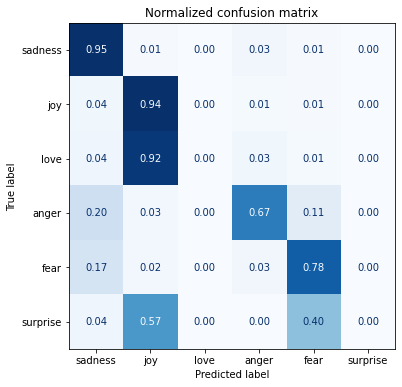

In [17]:
# Lets check the confusion matrix again.
# hide_output
preds_output = trainer.predict(emotions_encoded["validation"])
print(preds_output.metrics)
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)